In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Custom functions
import FPL_data

# SKlearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

Use our custom function to load the data from disk

In [2]:
# Download current data (only needs to be run once as will save data to json and csv)
week_number = 38
#week_number,_,_,_,_ = FPL_data.get_FPL_data()

In [3]:
week_number, plyr_df, team_df, next_game_df, history_df = FPL_data.load_FPL_data(week_number)

# Data Exploration

In [4]:
history_df.columns

Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards', 'player_id'],
      dtype='object')

In [5]:
print("There are {} unique players".format(history_df['player_id'].unique().shape[0]))

There are 645 unique players


In [6]:
player_id = 443
HTML(history_df[history_df['player_id']==player_id].to_html())

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,player_id
20825,0,10,0,0,0,3,0,0,9,0.6,0,0,443,0,0,9,0,2,0,1.9,443,0.4,0,2017-08-13T15:00:00Z,13 Aug 16:00,0,0,9,0,0,12,0,0,0,0,0,0,1,0,25136,0,0,0,0.0,4.0,18.0,0,0,0,0,50,False,0,0,443
20826,0,21,0,0,0,16,0,6,17,52.9,0,0,443,0,0,15,0,3,0,7.4,954,21.2,4,2017-08-19T14:00:00Z,19 Aug 15:00,0,0,90,0,3,14,0,0,0,0,2,0,2,0,27824,0,0,0,2.0,3.0,0.0,1,-1515,945,2460,50,False,0,0,443
20827,0,43,0,0,0,11,0,4,36,1.6,0,0,443,0,0,26,1,3,0,2.4,1470,11.2,0,2017-08-26T14:00:00Z,26 Aug 15:00,0,0,90,0,0,13,0,0,0,0,3,0,3,0,28464,0,0,1,0.0,3.0,11.0,1,-269,2323,2592,50,False,0,0,443
20828,0,22,1,0,0,23,1,3,14,47.1,0,0,443,0,0,40,1,0,0,6.2,2001,14.2,3,2017-09-11T19:00:00Z,11 Sep 20:00,0,0,90,0,2,8,0,0,0,0,4,0,4,0,28977,3,0,1,0.0,2.0,1.0,6,-338,2793,3131,50,True,0,0,443
20829,0,30,0,0,3,30,1,4,27,34.3,0,0,443,0,0,48,0,0,0,4.6,2545,11.2,2,2017-09-16T14:00:00Z,16 Sep 15:00,0,0,90,0,1,19,0,0,0,0,4,0,5,0,30355,0,0,0,0.0,0.0,0.0,9,905,3136,2231,50,False,0,0,443
20830,0,44,0,0,0,5,0,0,30,14.3,0,0,443,0,0,58,1,3,0,2.8,3091,11.4,0,2017-09-23T11:30:00Z,23 Sep 12:30,0,0,90,0,1,17,0,0,0,0,4,0,6,0,35059,6,2,0,3.0,2.0,2.0,1,3309,6037,2728,50,True,0,0,443
20831,0,40,0,0,0,27,1,4,30,33.8,0,0,443,0,0,67,1,0,0,5.7,3641,22.8,2,2017-09-30T14:00:00Z,30 Sep 15:00,0,0,90,0,2,16,0,0,0,0,5,0,7,0,59270,3,2,0,0.0,1.0,0.0,6,22776,26720,3944,50,True,0,0,443
20832,0,25,0,0,0,8,0,3,16,1.3,0,0,443,0,0,72,0,1,0,0.8,4195,6.4,0,2017-10-14T14:00:00Z,14 Oct 15:00,0,0,90,0,0,4,0,0,0,0,3,0,8,0,61725,0,0,0,1.0,1.0,0.0,2,1364,7453,6089,50,False,0,0,443
20833,0,0,0,0,0,0,0,0,0,0.0,0,0,443,0,0,90,0,0,0,0.0,4752,0.0,0,2017-10-20T19:00:00Z,20 Oct 20:00,0,0,0,0,0,3,0,0,0,0,0,0,9,0,70421,0,0,0,3.0,0.0,0.0,0,7986,10652,2666,50,True,0,0,443
20834,1,17,1,0,0,15,0,3,13,11.2,0,0,443,0,0,95,1,0,0,3.7,5311,23.6,1,2017-10-28T14:00:00Z,28 Oct 15:00,0,0,45,0,0,6,0,0,0,0,2,0,10,0,61476,1,0,0,2.0,2.0,2.0,4,-9169,1213,10382,50,False,0,0,443


In [7]:
HTML(plyr_df[plyr_df['id']==player_id].to_html())

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,dreamteam_count,ea_index,element_type,ep_next,ep_this,event_points,first_name,form,goals_conceded,goals_scored,ict_index,id,in_dreamteam,influence,loaned_in,loaned_out,loans_in,loans_out,minutes,news,news_added,now_cost,own_goals,penalties_missed,penalties_saved,photo,points_per_game,red_cards,saves,second_name,selected_by_percent,special,squad_number,status,team,team_code,threat,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards
610,7,10,577,100.0,100.0,9,55459,0,0,-1,1,550.6,0,0,2,3.0,5.5,5,Aaron,3.0,59,1,139.9,443,False,655.2,0,0,0,0,2892,,2018-04-16T19:01:19Z,49,0,0,0,55459.jpg,3.2,0,0,Cresswell,2.6,False,3.0,a,20,21,189.0,110,463363,3302,318363,470,0.6,22.4,Cresswell,7


Let's explore the target variable, total points.

In [8]:
history_df['total_points'].value_counts()

 0     12152
 1      3289
 2      2900
 6       836
 3       808
 5       374
 7       314
 8       284
 9       197
 4       154
 10       99
 11       80
-1        73
 12       67
 13       58
 15       44
 14       29
-2        24
 16       22
 17        8
 18        3
 20        2
 21        1
-3         1
 29        1
Name: total_points, dtype: int64

In [9]:
history_df['total_points'].describe()

count    21820.000000
mean         1.386801
std          2.509576
min         -3.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         29.000000
Name: total_points, dtype: float64

In [10]:
history_df['total_points'].shape[0]

21820

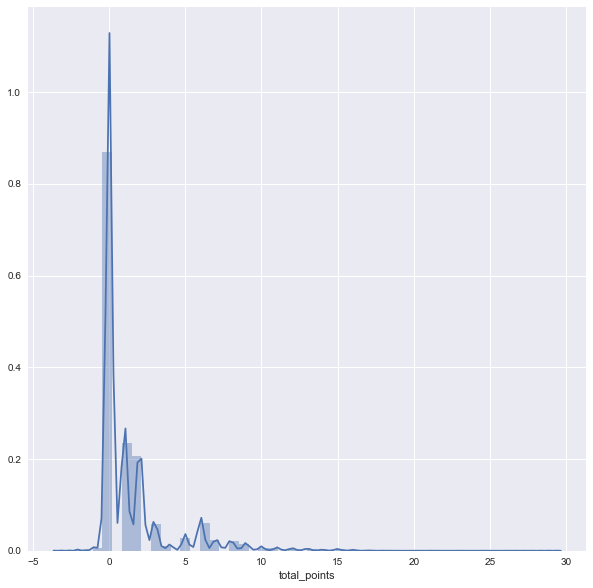

In [11]:
sns.distplot(history_df['total_points'])

There are many many zeroes here, do we have some players that never play/never score points?

In [12]:
player_summary = history_df[['player_id','total_points', 'minutes']].groupby(by='player_id').agg(sum)
idx = (player_summary['total_points'] == 0) & (player_summary['minutes'] == 0)
player_summary[idx].shape[0]

137

These are unlikely to be much use for prediction, so we'll probably remove them in the data prep stage

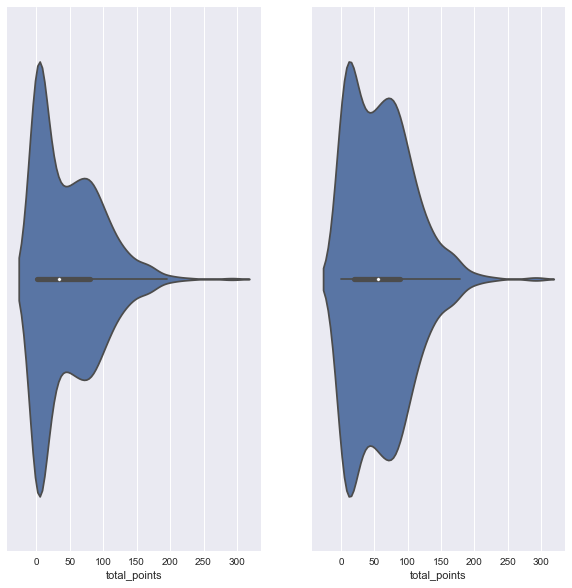

In [13]:
fig, ax = plt.subplots(ncols=2)
sns.violinplot(player_summary['total_points'], ax=ax[0])
sns.violinplot(player_summary[~idx]['total_points'], ax=ax[1])

In [14]:
plyr_df.columns

Index(['assists', 'bonus', 'bps', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'clean_sheets', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'creativity', 'dreamteam_count', 'ea_index',
       'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'goals_conceded', 'goals_scored', 'ict_index', 'id',
       'in_dreamteam', 'influence', 'loaned_in', 'loaned_out', 'loans_in',
       'loans_out', 'minutes', 'news', 'news_added', 'now_cost', 'own_goals',
       'penalties_missed', 'penalties_saved', 'photo', 'points_per_game',
       'red_cards', 'saves', 'second_name', 'selected_by_percent', 'special',
       'squad_number', 'status', 'team', 'team_code', 'threat', 'total_points',
       'transfers_in', 'transfers_in_event', 'transfers_out',
       'transfers_out_event', 'value_form', 'value_season', 'web_name',
       'yellow_cards'],
      dtype='object')

In [15]:
plyr_df['element_type'].unique()

array([1, 2, 3, 4], dtype=int64)

In [16]:
plyr_df[['web_name','element_type']]

,web_name,element_type
0,Ospina,1
1,Cech,1
2,Martinez,1
3,Koscielny,2
4,Mertesacker,2
5,Gabriel,2
6,Bellerín,2
7,Jenkinson,2
8,Monreal,2
9,Holding,2


In [17]:
team_df.columns

Index(['code', 'current_event_fixture', 'draw', 'form', 'id', 'link_url',
       'loss', 'name', 'next_event_fixture', 'played', 'points', 'position',
       'short_name', 'strength', 'strength_attack_away',
       'strength_attack_home', 'strength_defence_away',
       'strength_defence_home', 'strength_overall_away',
       'strength_overall_home', 'team_division', 'unavailable', 'win'],
      dtype='object')

In [19]:
HTML(team_df.to_html())

,code,current_event_fixture,draw,form,id,link_url,loss,name,next_event_fixture,played,points,position,short_name,strength,strength_attack_away,strength_attack_home,strength_defence_away,strength_defence_home,strength_overall_away,strength_overall_home,team_division,unavailable,win
0,3,"[{'is_home': True, 'day': 6, 'event_day': 3, '...",0,None,1,,0,Arsenal,"[{'is_home': False, 'day': 13, 'event_day': 1,...",0,0,0,ARS,4,1260,1200,1320,1260,1320,1230,1,False,0
1,91,"[{'is_home': True, 'day': 5, 'event_day': 2, '...",0,None,2,,0,Bournemouth,"[{'is_home': False, 'day': 13, 'event_day': 1,...",0,0,0,BOU,3,1070,1060,1120,1110,1140,1110,1,False,0
2,36,"[{'is_home': True, 'day': 4, 'event_day': 1, '...",0,None,3,,0,Brighton,"[{'is_home': False, 'day': 13, 'event_day': 1,...",0,0,0,BHA,2,1070,1060,1100,1020,1090,1030,1,False,0
3,90,"[{'is_home': False, 'day': 6, 'event_day': 3, ...",0,None,4,,0,Burnley,"[{'is_home': True, 'day': 13, 'event_day': 1, ...",0,0,0,BUR,3,1180,1170,1050,1050,1130,1130,1,False,0
4,8,"[{'is_home': True, 'day': 6, 'event_day': 3, '...",0,None,5,,0,Chelsea,"[{'is_home': False, 'day': 13, 'event_day': 1,...",0,0,0,CHE,4,1270,1250,1300,1280,1290,1250,1,False,0
5,31,"[{'is_home': False, 'day': 5, 'event_day': 2, ...",0,None,6,,0,Crystal Palace,"[{'is_home': True, 'day': 13, 'event_day': 1, ...",0,0,0,CRY,3,1100,1070,1080,1070,1100,1090,1,False,0
6,11,"[{'is_home': True, 'day': 5, 'event_day': 2, '...",0,None,7,,0,Everton,"[{'is_home': False, 'day': 13, 'event_day': 1,...",0,0,0,EVE,3,1170,1050,1140,1050,1150,1060,1,False,0
7,38,"[{'is_home': False, 'day': 6, 'event_day': 3, ...",0,None,8,,0,Huddersfield,"[{'is_home': True, 'day': 13, 'event_day': 1, ...",0,0,0,HUD,2,1050,1040,1030,1000,1050,1020,1,False,0
8,13,"[{'is_home': True, 'day': 5, 'event_day': 2, '...",0,None,9,,0,Leicester,"[{'is_home': False, 'day': 13, 'event_day': 1,...",0,0,0,LEI,3,1200,1110,1170,1160,1180,1140,1,False,0
9,14,"[{'is_home': False, 'day': 6, 'event_day': 3, ...",0,None,10,,0,Liverpool,"[{'is_home': True, 'day': 13, 'event_day': 1, ...",0,0,0,LIV,5,1290,1280,1320,1300,1330,1330,1,False,0
